### IMPORT REQUIREMENTS

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
XAU = pd.read_csv('./XAU_USD Historical Data.csv')
BTC = pd.read_csv('./Bitcoin Historical Data.csv')

In [3]:
print("----- GOLD -------------\n", XAU.head())
print("\n----- BITCOIN ----------\n", BTC.head())

----- GOLD -------------
          Date     Price      Open      High       Low  Vol. Change %
0  12/06/2023  2,028.76  2,018.97  2,035.93  2,018.82   NaN    0.46%
1  12/05/2023  2,019.42  2,030.15  2,041.33  2,010.02   NaN   -0.51%
2  12/04/2023  2,029.74  2,071.25  2,135.90  2,020.34   NaN   -1.99%
3  12/01/2023  2,070.90  2,034.49  2,075.34  2,033.75   NaN    1.73%
4  11/30/2023  2,035.75  2,044.80  2,047.59  2,031.84   NaN   -0.43%

----- BITCOIN ----------
          Date     Price      Open      High       Low     Vol. Change %
0  12/06/2023  43,734.6  44,076.2  44,144.5  43,466.7  101.41K   -0.78%
1  12/05/2023  44,076.2  41,989.6  44,424.1  41,424.9   96.84K    4.97%
2  12/04/2023  41,987.8  39,968.6  42,394.4  39,968.6  104.21K    5.05%
3  12/03/2023  39,970.2  39,456.8  40,178.9  39,280.3   35.27K    1.30%
4  12/02/2023  39,458.4  38,688.2  39,673.4  38,646.5   37.09K    1.99%


### DATA PREPROCESSING

* Data Cleaning

In [4]:
def df_CleanTransform(df):

    # change 'Date' to datetime format & sort by 'Date'
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)

    # change data type to float
    df['High'] = df['High'].str.replace(',', '').astype(float)
    df['Low'] = df['Low'].str.replace(',', '').astype(float)
    df['Open'] = df['Open'].str.replace(',', '').astype(float)
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    
    df['Change %'] = df['Change %'].str.rstrip('%').astype('float') / 100.0

    df.replace(np.nan, '12345.12345', inplace=True)
    df[df['Vol.'] == '12345.12345']
    df['Volume'] = df['Vol.'].str[:-1].astype(float)
    df['m'] = df['Vol.'].str[-1]
    change_value = {'K': 1000, 'M': 1000000, 'B': 1000000000, '5': 1}
    df['m'] = df['m'].map(change_value)
    df['Vol.'] = df['Volume']*df['m']
    df.replace(12345.1234, np.nan, inplace=True)
    df.drop(['Volume', 'm'], axis=1, inplace=True)

    return df

XAU = df_CleanTransform(XAU)
BTC = df_CleanTransform(BTC)

In [5]:
print("----- nulls in the GOLD dataset -------------\n", XAU.isna().sum())
print("\n----- nulls in the BITCOIN dataset ----------\n", BTC.isna().sum())

----- nulls in the GOLD dataset -------------
 Date           0
Price          0
Open           0
High           0
Low            0
Vol.        3889
Change %       0
dtype: int64

----- nulls in the BITCOIN dataset ----------
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64


In [6]:
XAU.drop('Vol.', axis=1, inplace=True)
BTC.dropna(subset=['Vol.'], inplace=True)

* Technical Feature Extraction

In [7]:
def technical_indicators(df):

    # Rate Of Change
    df['ROC_26'] = ta.momentum.ROCIndicator(close=df['Price'], window=26).roc()
    df['ROC_34'] = ta.momentum.ROCIndicator(close=df['Price'], window=34).roc()
    df['ROC_52'] = ta.momentum.ROCIndicator(close=df['Price'], window=52).roc()
    df['ROC_68'] = ta.momentum.ROCIndicator(close=df['Price'], window=68).roc()    
    df['ROC_78'] = ta.momentum.ROCIndicator(close=df['Price'], window=78).roc()
    df['ROC_102'] = ta.momentum.ROCIndicator(close=df['Price'], window=102).roc()

    # Exponential Moving Average
    df['EMA_14'] = ta.trend.EMAIndicator(close=df['Price'], window=14).ema_indicator() # short-term
    df['EMA_50'] = ta.trend.EMAIndicator(close=df['Price'], window=50).ema_indicator() # mid-term
    df['EMA_120'] = ta.trend.EMAIndicator(close=df['Price'], window=120).ema_indicator() # long-term

    # Relative Strength Index
    df['RSI_28'] = ta.momentum.RSIIndicator(close=df['Price'], window=28).rsi() #mid-term
    df['RSI_28_SMA14'] = ta.trend.SMAIndicator(close=df['RSI_28'], window=14).sma_indicator() # simple moving average of RSI

    # Moving Average Convergence Divergence - LongTerm
    df['MACD_long_macd'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd()
    df['MACD_long_diff'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd_diff()
    df['MACD_long_signal'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd_signal()

    # Moving Average Convergence Divergence - MidTerm
    df['MACD_mid_macd'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd()
    df['MACD_mid_diff'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd_diff()
    df['MACD_mid_signal'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd_signal()

    # Bollinger Bands - LongTerm
    df['BB_50_high'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_hband()
    df['BB_50_low'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_lband()
    df['BB_50_width'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_wband()
    df['BB_50_percentage'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_pband()

    # Bollinger Bands - MidTerm
    df['BB_20_high'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_hband()
    df['BB_20_low'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_lband()
    df['BB_20_width'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_wband()
    df['BB_20_percentage'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_pband()

    # Ichimoku Cloud
    df['IchiCloud_SpanA'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_a()
    df['IchiCloud_SpanB'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_b()
    df['IchiCloud_KijunSen'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_base_line()
    df['IchiCloud_TenkanSen'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_conversion_line()

    return df

XAU = technical_indicators(XAU)
BTC = technical_indicators(BTC)

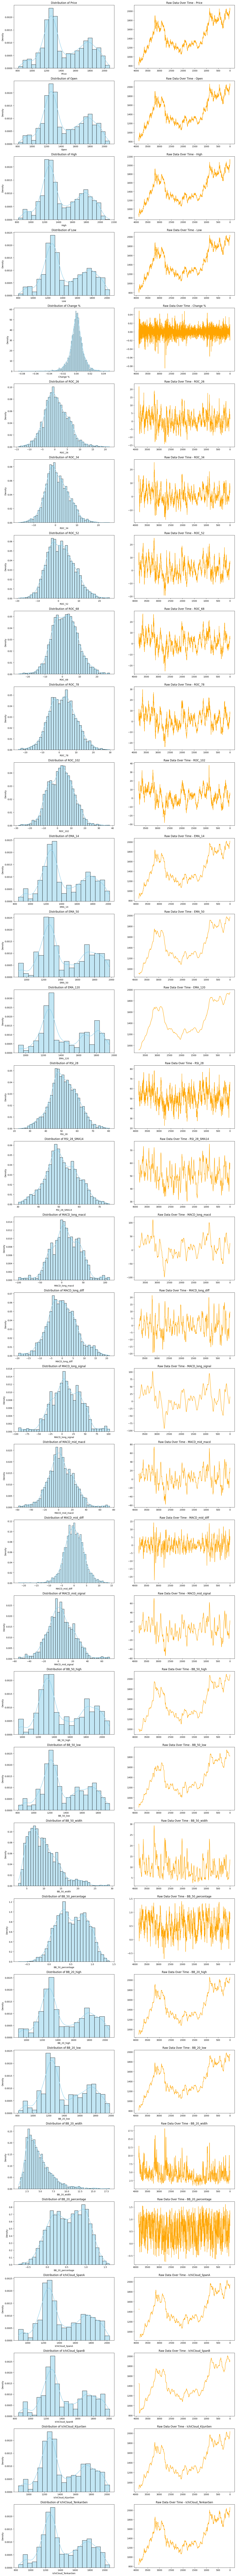

In [8]:
fig, axes = plt.subplots(nrows=len(XAU.columns[1:]), ncols=2, figsize=(18, 6 * len(XAU.columns)))

for i, column in enumerate(XAU.columns[1:]):
    # Distribution plot
    sns.histplot(XAU[column], kde=True, ax=axes[i, 0], color='skyblue', stat='density')
    axes[i, 0].set_title(f'Distribution of {column}')

    # Raw data over time
    XAU[column].plot(ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Raw Data Over Time - {column}')
    axes[i, 1].invert_xaxis() 

In [8]:
xau_test = XAU.copy()
xau_test.dropna(inplace=True)
xau_test.drop(['Date', 'High', 'Low', 'Open'], axis=1, inplace=True)

In [9]:
def maxmin_normalization(df, test_split):
    train_set = df.iloc[:int(test_split * len(df)),:]
    test_set = df.iloc[int(test_split * len(df)):,:]

    MaxMin = {}

    for column_ in df.columns:

        min_, max_ = min(train_set[f'{column_}']), max(train_set[f'{column_}'])
        MaxMin[f'{column_}'] = [min_, max_]

        train_set[f'{column_}'] = (train_set[f'{column_}'] - min_) / (max_ - min_)
        test_set[f'{column_}'] = (test_set[f'{column_}'] - min_) / (max_ - min_)

    df = pd.concat([train_set, test_set])
        
    return df, MaxMin

In [10]:
def to_supervised(df, target, n_input, n_output=1):

    target_series = df[f'{target}'].to_numpy()
    series = df.to_numpy()

    X = []
    Y = []

    i = 0
    while i < (len(df) - n_input - n_output + 1):
        
        inputs = [row for row in series[i:i+n_input]]
        X.append(inputs)

        outputs = target_series[i+n_input:i+n_input+n_output]
        Y.append(outputs)

        i += 1  

    return np.array(X), np.array(Y)

In [24]:
normal_xau, maxmin_dict = maxmin_normalization(xau_test, 0.8)
X, Y = to_supervised(normal_xau, 'Price', 150, 15)

X_Train, X_Test = X[:int(0.8 * len(X)),:], X[int(0.8 * len(X)):,:]
Y_Train, Y_Test = Y[:int(0.8 * len(Y)),:], Y[int(0.8 * len(Y)):,:]

n_steps , n_features, n_output = X_Train.shape[1], X_Train.shape[2], Y_Train.shape[1]

C:\Users\a.zohdi\AppData\Local\Temp\ipykernel_46176\3983724600.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[f'{column_}'] = (train_set[f'{column_}'] - min_) / (max_ - min_)
C:\Users\a.zohdi\AppData\Local\Temp\ipykernel_46176\3983724600.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[f'{column_}'] = (test_set[f'{column_}'] - min_) / (max_ - min_)


In [26]:
model_vanillaLSTM = Sequential()
model_vanillaLSTM.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features)))
model_vanillaLSTM.add(Dense(n_output))

model_vanillaLSTM.compile(optimizer='adam', loss='mse')
model_vanillaLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20)



Epoch 1/100

144/144 [==============================] - 4s 23ms/step - loss: 0.0116
Epoch 2/100
144/144 [==============================] - 3s 24ms/step - loss: 0.0016
Epoch 3/100
144/144 [==============================] - 3s 24ms/step - loss: 0.0013
Epoch 4/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0012
Epoch 5/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0013
Epoch 6/100
144/144 [==============================] - 3s 24ms/step - loss: 0.0012
Epoch 7/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0012
Epoch 8/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0012
Epoch 9/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0011
Epoch 10/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0011
Epoch 11/100
144/144 [==============================] - 3s 24ms/step - loss: 0.0011
Epoch 12/100
144/144 [==============================] - 3s 24ms/step - loss: 0.001

In [28]:
model_stackedLSTM = Sequential()
model_stackedLSTM.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_stackedLSTM.add(LSTM(64, activation='relu'))
model_stackedLSTM.add(Dense(n_output))

model_stackedLSTM.compile(optimizer='adam', loss='mse')
model_stackedLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 6s 31ms/step - loss: 0.0210
Epoch 2/100
144/144 [==============================] - 5s 31ms/step - loss: 0.0018
Epoch 3/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0017
Epoch 4/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0016
Epoch 5/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0014
Epoch 6/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0013
Epoch 7/100
144/144 [==============================] - 5s 31ms/step - loss: 0.0013
Epoch 8/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0014
Epoch 9/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0014
Epoch 10/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0012
Epoch 11/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0013
Epoch 12/100
144/144 [==============================] - 5s 32ms/step - loss: 0.0012
E

In [31]:
model_biLSTM = Sequential()
model_biLSTM.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(n_steps, n_features)))
model_biLSTM.add(Dense(n_output))

model_biLSTM.compile(optimizer='adam', loss='mse')
model_biLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 4s 18ms/step - loss: 0.0118
Epoch 2/100
144/144 [==============================] - 2s 17ms/step - loss: 0.0017
Epoch 3/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0014
Epoch 4/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0013
Epoch 5/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0012
Epoch 6/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 7/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 8/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 9/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 10/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0010
Epoch 11/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0010
Epoch 12/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0010
E

In [34]:
model_vanillaGRU = Sequential()
model_vanillaGRU.add(GRU(128, activation='tanh', input_shape=(n_steps, n_features)))
model_vanillaGRU.add(Dense(n_output))

model_vanillaGRU.compile(optimizer='adam', loss='mse')
model_vanillaGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 4s 23ms/step - loss: 0.0076
Epoch 2/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0015
Epoch 3/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0013
Epoch 4/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0013
Epoch 5/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0013
Epoch 6/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0012
Epoch 7/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0012
Epoch 8/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0013
Epoch 9/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0012
Epoch 10/100
144/144 [==============================] - 3s 23ms/step - loss: 0.0012
Epoch 11/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0011
Epoch 12/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0012
E

In [35]:
model_stackedGRU = Sequential()
model_stackedGRU.add(GRU(64, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model_stackedGRU.add(GRU(64, activation='tanh'))
model_stackedGRU.add(Dense(n_output))

model_stackedGRU.compile(optimizer='adam', loss='mse')
model_stackedGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 7s 35ms/step - loss: 0.0085
Epoch 2/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0014
Epoch 3/100
144/144 [==============================] - 5s 35ms/step - loss: 0.0013
Epoch 4/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0014
Epoch 5/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0013
Epoch 6/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0013
Epoch 7/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0012
Epoch 8/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0012
Epoch 9/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0012
Epoch 10/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0011
Epoch 11/100
144/144 [==============================] - 5s 33ms/step - loss: 0.0012
Epoch 12/100
144/144 [==============================] - 5s 34ms/step - loss: 0.0012
E

In [36]:
model_biGRU = Sequential()
model_biGRU.add(Bidirectional(GRU(64, activation='tanh'), input_shape=(n_steps, n_features)))
model_biGRU.add(Dense(n_output))

model_biGRU.compile(optimizer='adam', loss='mse')
model_biGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 4s 19ms/step - loss: 0.0165
Epoch 2/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0021
Epoch 3/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0016
Epoch 4/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0014
Epoch 5/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0013
Epoch 6/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0012
Epoch 7/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0013
Epoch 8/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0012
Epoch 9/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0012
Epoch 10/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0013
Epoch 11/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0011
Epoch 12/100
144/144 [==============================] - 3s 19ms/step - loss: 0.0011
E

In [39]:
model_vanillaRNN = Sequential()
model_vanillaRNN.add(SimpleRNN(128, activation='relu', input_shape=(n_steps, n_features)))
model_vanillaRNN.add(Dense(n_output))

model_vanillaRNN.compile(optimizer='adam', loss='mse')
model_vanillaRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 2s 9ms/step - loss: 0.0121
Epoch 2/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 3/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0015
Epoch 4/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 5/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0013
Epoch 6/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0013
Epoch 7/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 8/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 9/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 10/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 11/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 12/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 13/100


In [40]:
model_stackedRNN = Sequential()
model_stackedRNN.add(SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_stackedRNN.add(SimpleRNN(64, activation='relu'))
model_stackedRNN.add(Dense(n_output))

model_stackedRNN.compile(optimizer='adam', loss='mse')
model_stackedRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 3s 17ms/step - loss: 0.0323
Epoch 2/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0019
Epoch 3/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0015
Epoch 4/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0014
Epoch 5/100
144/144 [==============================] - 3s 18ms/step - loss: 0.0013
Epoch 6/100
144/144 [==============================] - 2s 17ms/step - loss: 0.0012
Epoch 7/100
144/144 [==============================] - 2s 17ms/step - loss: 0.0013
Epoch 8/100
144/144 [==============================] - 2s 17ms/step - loss: 0.0012
Epoch 9/100
144/144 [==============================] - 3s 24ms/step - loss: 0.0011
Epoch 10/100
144/144 [==============================] - 4s 31ms/step - loss: 0.0011
Epoch 11/100
144/144 [==============================] - 5s 31ms/step - loss: 0.0011
Epoch 12/100
144/144 [==============================] - 5s 32ms/step - loss: 0.0011
E

In [41]:
model_biRNN = Sequential()
model_biRNN.add(Bidirectional(SimpleRNN(64, activation='relu'), input_shape=(n_steps, n_features)))
model_biRNN.add(Dense(n_output))

model_biRNN.compile(optimizer='adam', loss='mse')
model_biRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20)

Epoch 1/100
144/144 [==============================] - 3s 16ms/step - loss: 0.0278
Epoch 2/100
144/144 [==============================] - 2s 15ms/step - loss: 0.0028
Epoch 3/100
144/144 [==============================] - 2s 15ms/step - loss: 0.0021
Epoch 4/100
144/144 [==============================] - 2s 15ms/step - loss: 0.0018
Epoch 5/100
144/144 [==============================] - 2s 16ms/step - loss: 0.0016
Epoch 6/100
144/144 [==============================] - 2s 15ms/step - loss: 0.0015
Epoch 7/100
144/144 [==============================] - 2s 15ms/step - loss: 0.0015
Epoch 8/100
144/144 [==============================] - 3s 22ms/step - loss: 0.0014
Epoch 9/100
144/144 [==============================] - 4s 28ms/step - loss: 0.0013
Epoch 10/100
144/144 [==============================] - 4s 28ms/step - loss: 0.0012
Epoch 11/100
144/144 [==============================] - 4s 28ms/step - loss: 0.0012
Epoch 12/100
144/144 [==============================] - 4s 30ms/step - loss: 0.0012
E

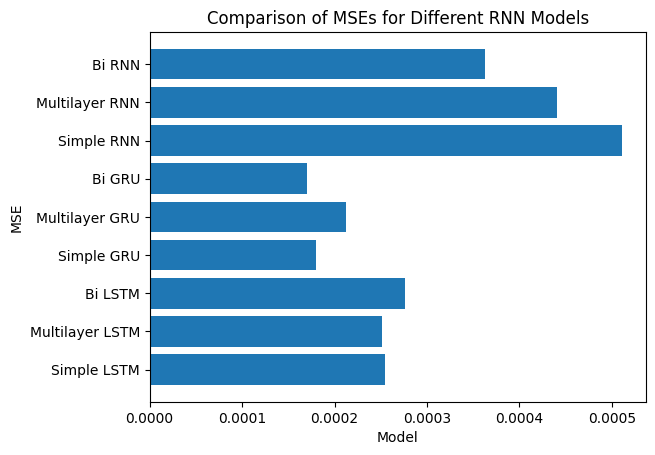

In [46]:
model_names = ['Simple LSTM', 'Multilayer LSTM', 'Bi LSTM', 'Simple GRU', 'Multilayer GRU', 'Bi GRU', 'Simple RNN', 'Multilayer RNN', 'Bi RNN']

model_mse = [model_vanillaLSTM.history.history['loss'][-1], model_biLSTM.history.history['loss'][-1], model_stackedLSTM.history.history['loss'][-1],
             model_vanillaGRU.history.history['loss'][-1], model_biGRU.history.history['loss'][-1], model_stackedGRU.history.history['loss'][-1],
             model_vanillaRNN.history.history['loss'][-1], model_biRNN.history.history['loss'][-1], model_stackedRNN.history.history['loss'][-1]]

plt.barh(model_names, model_mse)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Comparison of MSEs for Different RNN Models')
plt.show()